In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

import numpy as np
import matplotlib.pyplot as plt

Read and View Data

In [2]:
df = pd.read_csv('train.csv')
print df.head(5)
print df.describe()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

Data Cleasing

In [3]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

In [4]:
df['Age'].describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [5]:
df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [6]:
df.loc[df['Sex'] == 'male', 'Sex'] = 0
df.loc[df['Sex'] == 'female', 'Sex'] = 1

In [7]:
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [8]:
df = df.join(pd.get_dummies(df.Pclass, prefix='Pclass'))

In [9]:
df = df.join(pd.get_dummies(df.Embarked, prefix='Embarked', dummy_na=True))

In [10]:
df = df.drop(['Embarked_nan', 'Embarked', 'Pclass'], axis=1)

In [11]:
df['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())

In [13]:
df['Fare'] = (df['Fare'] - df['Fare'].min()) / (df['Fare'].max() - df['Fare'].min())

In [37]:
df['sqrt_fare'] = df['Fare']
df['sqrt_fare'] = df['sqrt_fare'].apply(lambda x: x ** 0.5)

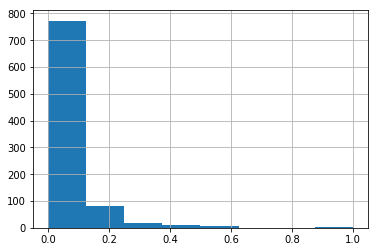

In [27]:
plt.clf()
df['Fare'].hist(bins=8).figure

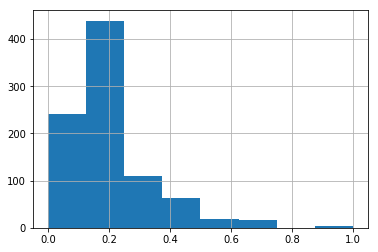

In [38]:
plt.clf()
df['sqrt_fare'].hist(bins=8).figure

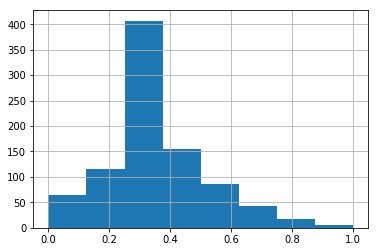

In [22]:
plt.clf()
df['Age'].hist(bins=8).figure

In [44]:
df.columns

Index([u'PassengerId', u'Survived', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Fare', u'Pclass_1', u'Pclass_2', u'Pclass_3', u'Embarked_C',
       u'Embarked_Q', u'Embarked_S', u'sqrt_fare'],
      dtype='object')

In [45]:
factors = ['Sex', 'Age', 'SibSp', 'Parch', 'sqrt_fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [46]:
alg = LogisticRegression(random_state=1)
scores = cross_val_score(alg, df[factors], df['Survived'], cv=3)
print scores.mean()

0.793490460157


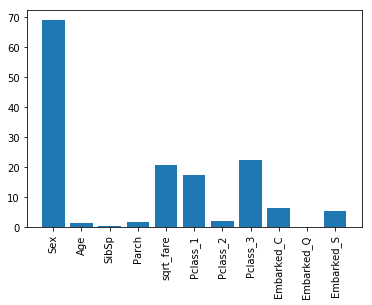

In [58]:
selector = SelectKBest(f_classif, k=5)
selector.fit(df[factors], df['Survived'])

scores = -np.log10(selector.pvalues_)

plt.clf()
plt.bar(range(len(factors)), scores)
plt.xticks(range(len(factors)), factors, rotation='vertical')
plt.show()

In [65]:
factors_K = ['Sex', 'sqrt_fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_S', 'Embarked_Q']

alg = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)
scores = cross_val_score(alg, df[factors_K], df['Survived'], cv=3)
print scores.mean()

0.792368125701


In [69]:
factors = ['Sex', 'Age', 'SibSp', 'Parch', 'sqrt_fare', 'Pclass_1', 'Pclass_2',\
           'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

alg = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)
kf = KFold(df.shape[0], n_folds=3, random_state=1)
predictions = []

for train, test in kf:
    train_target = df['Survived'].iloc[train]
    alg.fit(df[factors].iloc[train, :], train_target)
    test_predictions = alg.predict_proba(df[factors].iloc[test, :].astype(float))[:, 1]
    test_predictions[test_predictions <= 0.5] = 0
    test_predictions[test_predictions > 0.5] = 1
    predictions.append(test_predictions)
    
predictions = np.concatenate(predictions, axis=0)
accuracy = sum(map(lambda x, y : x == y, predictions, df['Survived'])) / (len(df['Survived']) * 1.0)
print accuracy

0.804713804714
